# Solving a Vehicle Routing Problem with Mixed Integer Linear Programming (PuLP)

## Problem

$m$ couriers must distribute $n ≥ m$ items at different customer locations. Each courier $i$ has a maximum load size $l_i$. Each item $j$ has a distribution point $j$ and a size $s_j$ (which can represent a weight or a volume). The goal is to assign each courier the items to be distributed and plan a tour (i.e. a sequence of location points to visit) to perform the necessary distribution tasks. Each courier tour must start and end at a given origin point $O$ (depot). Moreover, the maximum load $l_i$ of the courier $i$ should be respected when items are assigned to it. To achieve a fair division among drivers, the objective is to minimize the maximum distance travelled by any courier. All couriers must contribute to the items delivery.

### Instance format 

An instance of VRP is a text file of the form: 

$m$<br>
$n$<br>
$l_1,l_2,...,l_m$<br>
$s_1,s_2,...,s_n$<br>
$D_{1,1},D_{1,2},...D_{1,n+1}$<br>
$D_{2,1},D_{1,2},...D_{1,n+1}$<br>
$...$<br>
$D_{n,1},D_{n,2},...D_{n,n+1}$<br>
$D_{n+1,1},D_{n+1,2},...D_{n+1,n+1}$<br>


where $D_{ij}$ is the distance between distribution point $i$ and distribution point $j$ for $i,j=1,...,n+1$. In particular, distribution point $n + 1$ corresponds to the origin origin point (clearly, $D_{ii}=0$ for $i=1,...,n+1$). For example, the following instance file (.dat):

```
3
7
15 10 7
3  2  6  8  5  4  4
0  3  3  6  5  6  6  2
3  0  4  3  4  7  7  3
3  4  0  7  6  3  5  3
6  3  7  0  3  6  6  4
5  4  6  3  0  3  3  3
6  7  3  6  3  0  2  4
6  7  5  6  3  2  0  4
2  3  3  4  3  4  4  0
```
corresponds to a VRP instance with 3 couriers and 7 items where, e.g., $D_{2,n+1}=D_{2,8}=3$ is the distance between the distribution point 2 to $O$, while $D_{4,7}=6$ is the distance between the distribution points 4 and 7. Note that in general $D$ is *not* guaranteed to be symmetrical, i.e., it is possible that $D_{i,j}\not=D_{j,i}$. 



# Solution

## Decision variables

### $trips$ variable

3d array of binary values ($0..1$). The 3d array has size $[1..m,1..n+1,1..n+1]$. Used to represent for each courier trip (first dimension $1..n$) the delivered items, a 2d array with dimension $(n+1)×(n+1)$. 

Specifically: 
- each courier trip is represented by a $(n+1)\times (n+1)$ matrix of boolean values $0..1$.
- each courier matrix identifies the item picked for delivery and points to next item with the same logic defined for input matrix D.
- value 0 for all cells in the same column means courier is not delivering that item (item = column index with base 1).
- value 1 in one cells of the column means courier delivers that itme (item = column index  with base 1) and then proceed to pick next item defined in row=column index.  
- as per input matrix D, row=$n+1$ and column=$n+1$ identify depots (start and end).
- first item picked by courier is the one with row=$n+1$ 

Here an example matrix for 2 couriers (<span style="color:red">Red</span>=courier #1, <span style="color:green">Green</span>=courier #2) delivering 4 items (3d array $2 x 5 x 5$):

<table style="font-size:15px;width:200px;text-align: center">
<!--         <td style="color:red;"><b>1</b></td> -->
    <tr>
        <td>0</td>
        <td>0</td>
        <td style="color:red;background-color:yellow"><b>1</b></td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td style="color:red;background-color:yellow"><b>1</b></td>
    </tr>
    <tr>
        <td style="color:red;background-color:yellow"><b>1</b></td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td style="color:red;background-color:yellow"><b>1</b></td>
        <td>0</td>
    </tr>
</table>
<br/>
Can be read as: 

- <span style="color:red">courier #1</span> starts from depot (row $n+1=5$) and picks item 4 -> $(5,4)$.  
- <span style="color:red">courier #1</span> then picks item 1-> $(4,1)$. 
- <span style="color:red">courier #1</span> then picks item 3-> $(1,3)$. 
- <span style="color:red">courier #1</span> then goes to depot (column $n+1=5$)-> $(3,5)$. 
- <span style="color:red">courier #1</span> matrix 2nd column 2 is all zeroes, i.e. doesn't deliver that item. 
<br/>
<table style="font-size:15px;width:200px;text-align: center">
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td style="color:green;background-color:yellow"><b>1</b></td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td style="color:green;background-color:yellow"><b>1</b></td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
</table>

Can be read as: 

- <span style="color:green">courier #2</span> starts from depot and picks item 2-> $(5,2)$.  
- <span style="color:green">courier #2</span> then goes to depot-> $(2,5)$. 
- <span style="color:green">courier #2</span> matrix has 1st, 3rd and 4th column of all zeroes, i.e. doesn't deliver items 1,3 and 4. 

#### Observations

Looking at the 2 matrices aggregated:
<table style="font-size:15px;width:200px;text-align: center">
    <tr>
        <td>0</td>
        <td>0</td>
        <td style="color:red;background-color:yellow"><b>1</b></td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td style="color:green;background-color:yellow"><b>1</b></td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td style="color:red;background-color:yellow"><b>1</b></td>
    </tr>
    <tr>
        <td style="color:red;background-color:yellow"><b>1</b></td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td style="color:green;background-color:yellow"><b>1</b></td>
        <td>0</td>
        <td style="color:red;background-color:yellow"><b>1</b></td>
        <td>0</td>
    </tr>
</table>

we can observe some patterns:

- the sum of each rows but last one (depot start) equals $1$
- the sum of each column but last one (depot end) equals $1$
- the sum of depot row equals $m$
- the sum of depot column equals $m$
- diagonal values are all $0$
- each row and column with same index have sum <= $1$ (either $0$ or $1$)

There are also some symmetries to be looked after, which represent a special case wrt previous observations:

#### Depot symmetry

As per previous example this symmetry is legit, courier picks item #2 and goes back to depot.
<table style="font-size:15px;width:200px;text-align: center">
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td style="color:green;background-color:yellow"><b>1</b></td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td style="color:green;background-color:yellow"><b>1</b></td><td>0</td><td>0</td><td>0</td>
    </tr>
</table>

#### Non-depot symmetry

This is not allowed because the two positions point to each other and they represent an internal loop.
<table style="font-size:15px;width:200px;text-align: center">
    <tr>
        <td>0</td><td>0</td><td style="color:red;background-color:yellow"><b>1</b></td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td style="color:red;background-color:yellow"><b>1</b></td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
</table>

#### Loops with n>2 items

This is also not allowed because the n>2 positions form a loop, which can't be connected with depots.
<table style="font-size:15px;width:200px;text-align: center">
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td style="color:red;background-color:yellow"><b>1</b></td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td style="color:red;background-color:yellow"><b>1</b></td><td>0</td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td style="color:red;background-color:yellow"><b>1</b></td><td>0</td><td>0</td>
    </tr>
    <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>0</td>
    </tr>
</table>

An interesting property of these loops, however they are composed of 2,3 or more items is that the coordinates of these items have the sum of the rows index matching the sum of the columns indexes. Looking at the above example we can see that the coordinates are:

- (2,4)
- (3,2)
- (4,3)

and we can see that both indexes sum $9$

### $courier\_items$ variable

1d array to assign every items to each courier. It has range $1..n$ (items size) and values $1..m$ (couriers size). E.g.

<table style="font-size:15px;width:200px;border:1px">
    <tr>
        <td>3</td>
        <td>2</td>
        <td>2</td>
        <td>1</td>
        <td>3</td>
        <td>1</td>
    </tr>
</table>

Can be read as: 
* item #1 is assigned to courier \#3
* item #2 is assigned to courier \#2
* item #3 is assigned to courier \#2
* item #4 is assigned to courier \#1 
* and so on. 


## Objective function

The objective is to minimize the distance travelled by *any* courier. We can then formalise the objective function as:
$$ obj=\sum_{i=1}^{m}\sum_{j=1}^{n+1}\sum_{k=1}^{n+1}D_{jk}*trips_{ijk}$$ 


## Constraints


### All items must be delivered
The constraint can be interpreted as that aggregated couriers matrices in $trips$ variable must have exactly one value=1 for each column, except for depot column (index $n+1$). The same for each row: all aggregated couriers matrices must have exactly one value=1 in each row, except for depot row (index $n+1$). Formally: 
$$\sum_{i=1}^{m}\sum_{k=1}^{n+1}trips_{ikj}=1\quad\forall j\in 1..n$$ 

$$\sum_{i=1}^{m}\sum_{k=1}^{n+1}trips_{ijk}=1\quad\forall j\in 1..n$$

### Aggregated courier matrix last row and column must equals $m$ 
Each courier will start from depot (row=$n+1$) and deliver to depot (column=$n+1$), so aggregating all couriers matrices the sum of row=$n+1$ must be $m$, same for the sum of column with index $n+1$:

$$\sum_{i=1}^{m}\sum_{j=1}^{n+1}trips_{ij_{n+1}}= m$$
$$\sum_{i=1}^{m}\sum_{j=1}^{n+1}trips_{i_{n+1}j}= m$$

### The diagonal of each courier matrix must be $0$s
Diagonal should be ignored (all zeroes):

$$\sum_{i=1}^{m}\sum_{j=1}^{n+1}trips_{ijj}=0$$ 

### Each single courier matrix row and columns sum must be less or equal to $1$
Each row and column of $trips$ individual courier matrix must have each rows and columns (including depots) summing less or equal to $1$:

$$ \sum_{k=1}^{n+1}trips_{ikj}<=1\quad\forall m \in 1..m, \forall j \in 1..n+1$$

$$ \sum_{k=1}^{n+1}trips_{ijk}<=1\quad\forall m \in 1..m, \forall j \in 1..n+1$$


### Each courier shouldn't carry more than their max load
Each courier has a max load defined in the $couriers_j$ variable. We need to make sure the sum of each item assigned to a courier is not exceeding it's max load: 

$$\sum_{j=1}^{n}\sum_{k=1}^{n+1}items_j*trips_{ikj} <= couriers_i \quad\forall i\in 1..m$$

### Each courier matrix columns and rows with same index must have same sum
As visible from the matrices example in the $trips$ variable description, each courier matrix must show rows and columns with same index having the same sum (0 or 1):

$$\sum_{k=1}^{n+1}trips_{ikj}=\sum_{k=1}^{n+1}trips_{ijk} \quad\forall i \in 1..m \quad\forall j \in 1..n+1$$ 

### Symmetric $1$s are allowed only in depot row/columns
Symmetric $1$s are allowed only in depot row/columns (see courier #2 example above in green), which represent a courier trip delivering a single item. A symmetry in the non-depot cells would represent a loop which is not allowed (the courier would never pick up and deliver to depot).

$$ \sum_{j=1}^{n}\sum_{k=1}^{n} (Trips_{ijk} + Trips_{ikj}) <= 1 \quad \forall m \in 1..m$$

### Symmetry breaking to avoid internal loops
As expressed in the observation a characteristic of internal loops is that sum of coordinates match, to avoid them we need to force ordering, i.e. either forcing, for each courier matrix, sum of rows indexes to be >= sum of column indexes - 1 or vice-versa:

$$ \sum_{i=1}^{m}\sum_{j=1}^{n}\sum_{k=1}^{n} ((trips_{ijk}*j >= trips_{ijk}*k-1) + (trips_{ijk}*k >= trips_{ijk}*j-1)) <= 1 $$

<!--  for i in range(m):
        for j in range(n):
            for k in range(n):
               prob += lpSum(((Trips[i][j][k]*j)-1 <= (Trips[i][j][k]*k)) + (Trips[i][j][k]*j) >= ((Trips[i][j][k]*k)-1)) <= 1 -->

# Implementation

The solution was implemented using [PuLP](https://coin-or.github.io/pulp/) a Linear Programming modeler written in Python. 

In [1]:
!pip install pulp

In [2]:
from pulp import *
import numpy as np
import pulp as pl
import json
import pandas as pd
import numpy as np
import datetime
import time

In [3]:
def get_inst_from_file(inst):
  inst = str(inst).zfill(2)
  inst = f"inst{str(inst)}"
  inst_file_path = f"/kaggle/input/vehicle-router-problem-instances/{inst}.dat"
  instance = pd.read_csv(inst_file_path, delimiter='\t')
  if len(instance) < 5:
      print("Invalid params, expecting 5 parameters (m,n,couriers,items,D)")
      quit()

  m = 0
  n = 0
  couriers = []
  items = []
  D = []

  f =  open(inst_file_path,'r')
  lines = f.readlines()
  f.close()
  line_count = 0
  for line in lines:
      if line_count == 0:
        m = int(line)
      elif line_count == 1:
        n = int(line)
      elif line_count == 2:
        couriers = [int(x) for x in line.split()]
      elif line_count == 3:
        items = [int(x) for x in line.split()]
      elif line_count > 3:
        line = line.replace('\n','')
        D.append( [int(x) for x in line.split()] )
      line_count += 1

  results = {
          "m": m,
          "n": n,
          "couriers": couriers,
          "items": items,
          "D": D,
          }
  return json.dumps(results) 

In [4]:
# utils
def to_trips(solution_matrix,n):
    ret = []
    for item in solution_matrix:
        ret_item = []
        index = list(item[n]).index(1)
        while index != n:
            #print(index)
            ret_item.append(index+1)
            index = list(item[index]).index(1)
        ret.append(ret_item)
    #print(ret)
    return ret

def to_single_matrix(solution_matrix):
    ret = np.zeros(np.array(solution_matrix[0]).shape)
    for x, matrix in enumerate(solution_matrix):
        ret = ret + np.matrix([[(x+1) if i == 1 else 0 for i in row] for row in np.array(matrix)])
    return ret

def print_sol(Trips, m, n):
    for i in range(m):
        print('-'*20)
        for j in range(n+1):
            print([int(value(Trips[i][j][k])) for k in range(n+1)])

def print_solution_matrix(trips):
    for item in trips:
        print('---')
        for row in item:
            print(row)

In [5]:
# Model

def run_mip_model(solver_name, inst):
    print(f'loading instance #{inst}...')
    instance = json.loads(get_inst_from_file(inst))

    m = instance['m']
    n = instance['n']
    couriers = instance['couriers']
    items = instance['items']
    D = instance['D']
    prob = LpProblem("Multiple_Courier_Planning", LpMinimize)

    # decision variables
    Trips = LpVariable.dicts('trips',(range(m),range(n+1),range(n+1)), cat='Binary')
    Max = LpVariable('max_distance', lowBound=0, cat='Integer')

    # problem
    prob = LpProblem("max_distance", LpMinimize)
    #print(prob)

    # objective function
    prob += Max

    #############
    # Constraints
    #############

    # minimize max
    for i in range(m):
        prob += Max >= [Trips[i][j][k] * D[j][k] for j in range(n+1) for k in range(n+1)]

    print('loading constraints...')

    # all couriers must be assigned an item
    for j in range(n):
        # aggregated columns (except last) sum == 1
        prob += lpSum([Trips[i][k][j] for i in range(m) for k in range(n+1)]) == 1
        # aggregated rows (except last) sum == 1
        prob += lpSum([Trips[i][j][k] for i in range(m) for k in range(n+1)]) == 1

    # aggregated last columns must sum m
    prob += lpSum([Trips[i][k][n] for i in range(m) for k in range(n+1)]) == m
    # aggregated last rows must sum m
    prob += lpSum([Trips[i][n][k] for i in range(m) for k in range(n+1)]) == m

    # diagonal must be 0
    for i in range(m):
        for j in range(n+1):
            prob += Trips[i][j][j] == 0

    # the sum of each courier matrix rows (resp column) must be <=1
    for i in range(m):
        for j in range(n+1):
            # cols
            prob += lpSum([Trips[i][k][j] for k in range(n+1)]) <= 1
            # rows
            prob += lpSum([Trips[i][j][k] for k in range(n+1)]) <= 1

    # couriers should be assigned items based on their max load
    for i in range(m):
        prob += lpSum([items[j] * Trips[i][k][j] for j in range(n) for k in range(n+1)]) <= couriers[i]

    # each courier matrix column sum must be equivalent to sum of the row with same index (either 0 or 1)
    for i in range(m):
        for j in range(n+1):
                prob += lpSum([Trips[i][k][j] for k in range(n+1)]) == lpSum([Trips[i][j][k] for k in range(n+1)])

    # symmetric 1s are allowed only in depot row/column
    for i in range(m):
        for j in range(n):
            for k in range(n):
               prob += (Trips[i][j][k] + Trips[i][k][j]) <= 1

    # loops sum of row positions equal sum of col positions, we impose symmetry breaking here forcing that sum of row indexes is either >= sum of cols indexes -1 or vice-versa
    for i in range(m):
        for j in range(n):
            for k in range(n):
               prob += lpSum(((Trips[i][j][k]*j)-1 <= (Trips[i][j][k]*k)) + (Trips[i][j][k]*j) >= ((Trips[i][j][k]*k)-1)) <= 1

    print(f'invoking mip solver {solver_name}... ')
    print("\033[32;5mSolving...\033[0m")

    if solver_name == 'cbc':
        solver = pl.getSolver('PULP_CBC_CMD', msg=0)
    elif solver_name == 'highs':
        solver = pl.getSolver('HiGHS_CMD', msg=0)
    else:
        raise Exception(f'invalid solver: {solver_name}')

    start_time = time.time()
    prob.solve(solver)
    elapsed_time = time.time() - start_time
    print('Solved!')

    # all couriers distances
    distances = [sum([value(Trips[i][j][k]) * D[j][k] for j in range(n+1) for k in range(n+1)]) for i in range(m) ]

    # max distance consumed
    max_distance = np.max(distances)

    solution_matrix = []
    for i in range(m):
        item = [[int(value(Trips[i][j][k])) for k in range(n+1)] for j in range(n+1)]
        solution_matrix.append(item)

    np.array([[[value(Trips[i][j][k]) for j in range(n+1)] for k in range(n+1)] for i in range(m)])
    results = {
          "couriers": m,
          "items": n,
          "status": LpStatus[prob.status],
          "obj": int(max_distance),
          "exec_time_secs": round(elapsed_time,2),
          "trips": to_trips(solution_matrix,n),
          "trips_matrix" : solution_matrix,
          "aggregated_matrix": to_single_matrix(solution_matrix),
          "solver": solver_name,
          "distances": D
      }
    return results

----------
loading instance #1...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #2...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #3...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #4...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #5...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #6...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #7...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #8...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #9...
loading constraints...
invoking mip solver cbc... 
Solving...
Solved!
----------
loading instance #10...
loading constraints...
invoki

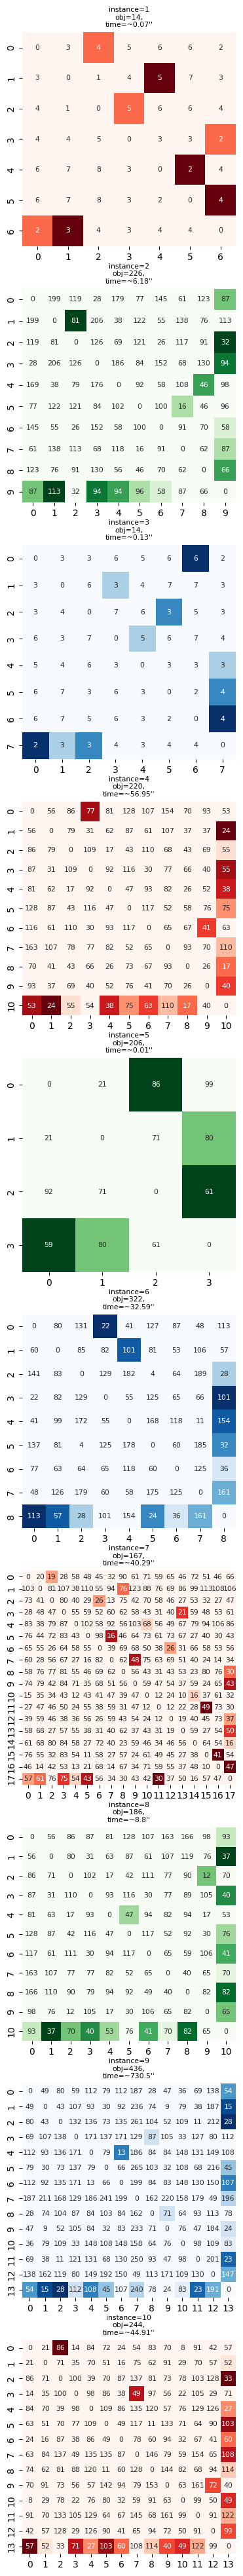

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

instances = 10
f,ax=plt.subplots(instances,1,figsize=(5,5*instances))
sns.set(font_scale=0.65)

for i in range(1,instances+1):
    print('-'*10)
    cm = ['Blues', 'Reds', 'Greens']
    res = run_mip_model('cbc',i)
    #res = run_mip_model('highs',i)
    sns.heatmap(res["aggregated_matrix"],ax=ax[i-1],cmap=cm[i%3],annot=res["distances"],fmt='',cbar=False, square=True,)
    ax[i-1].set_title(f'instance={i}\nobj={res["obj"]},\ntime=~{res["exec_time_secs"]}\'\'')
    